In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import calendar
import xgboost as xgb

from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [3]:
#Connecting to google drive via colab to access data
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Springboard/miniProjects/UltimateChallenge

Mounted at /content/drive
/content/drive/My Drive/Springboard/miniProjects/UltimateChallenge


In [4]:
#Loading datat into Dataframe
df = pd.read_json('ultimate_data_challenge.json')

# Question#1: 

Now that the data is imported let's take a look at it

In [27]:
print(df.head())
print('')
print(df.shape)
print('')
print(df.dtypes)

             city  trips_in_first_30_days signup_date  avg_surge  \
0  King's Landing                       4  2014-01-25       1.10   
1         Astapor                       0  2014-01-29       1.00   
2         Astapor                       3  2014-01-06       1.00   
3  King's Landing                       9  2014-01-10       1.14   
4      Winterfell                      14  2014-01-27       1.19   

  last_trip_date    phone  surge_pct  ultimate_black_user  weekday_pct  \
0     2014-06-17   iPhone       15.4                 True         46.2   
1     2014-05-05  Android        0.0                False         50.0   
2     2014-01-07   iPhone        0.0                False        100.0   
3     2014-06-29   iPhone       20.0                 True         80.0   
4     2014-03-15  Android       11.8                False         82.4   

   avg_dist  avg_rating_by_driver  retained  
0      3.67                   5.0         1  
1      8.26                   5.0         0  
2      0

Looks good except for signup_date & last_trip_date, they should be converted  to a datetime type.

In [8]:
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [9]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


Values look good, all within reasonable bounds, lets check for NaN's

In [10]:
df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

We can forward fill in the phone feature and fill in the avg_rating_by_driver feature with the average overall rating. avg_rating_of_driver is more difficult due to the number of invalid entries.  Considering avg_rating_of_driver and avg_rating_by_driver are very similar, the distinction is somewhat confusing, I will just drop the column.

In [11]:
df.phone.fillna(method = 'ffill', inplace=True)
df['avg_rating_by_driver'][df['avg_rating_by_driver'].isna()] = df['avg_rating_by_driver'].mean()

for col in list(df.columns):
    if col == 'avg_rating_of_driver': 
        df.drop(columns = 'avg_rating_of_driver', inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
for col in df.select_dtypes(include=['object']).columns:
    print(pd.unique(df[col]))

["King's Landing" 'Astapor' 'Winterfell']
['iPhone' 'Android']


Data looks good now.  Moving onto EDA and modeling

# Question #2

In [13]:
#creating new column that indicates whether rider was retained or not, 1 being they were retained 0 they were not
df['retained'] = 0
df['retained'][df['last_trip_date'] > (df.last_trip_date.max() - timedelta(30))] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


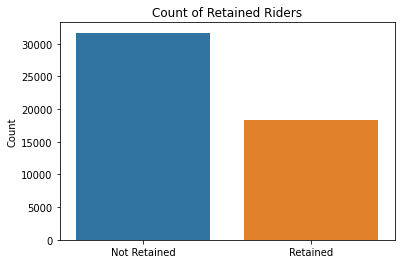

Number of Retained Riders:  18310
Number of Not Retained Riders:  31690
Percent of Retained Riders:  36.62 %
Percent of Not Retained Riders:  63.38 %


In [14]:
#Count plot of Retained Riders
count = sns.countplot(x = 'retained', data = df)
count.set(xlabel = '', ylabel = 'Count', title = 'Count of Retained Riders')
count.set_xticklabels(['Not Retained', 'Retained'])
plt.show()

print("Number of Retained Riders: ", df.retained.sum())
print("Number of Not Retained Riders: ", len(df) - df.retained.sum())
print("Percent of Retained Riders: ", round((df.retained.sum()/len(df) * 100), 2), '%')
print("Percent of Not Retained Riders: ", round(((len(df) - df.retained.sum())/len(df) * 100), 2), '%')

A little over a third of all users were considered retained.

In [17]:
#dummy encoding categorical features
dff = pd.get_dummies(df, columns=['city', 'phone'])

In [21]:
#Dropping datetime features as they aren't allowed in the model
X_train, X_test, y_train, y_test = train_test_split(dff.drop(columns=['retained', 'signup_date', 'last_trip_date']), dff['retained'], test_size=0.2, random_state=123)

In [22]:
#Our data is pretty well distributed, but I like XGBoost so why not :)
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

In [23]:
print('XGBoost Classifier')
print(metrics.classification_report(y_test, xgb_pred))

XGBoost Classifier
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      6317
           1       0.74      0.66      0.70      3683

    accuracy                           0.79     10000
   macro avg       0.78      0.76      0.77     10000
weighted avg       0.79      0.79      0.79     10000



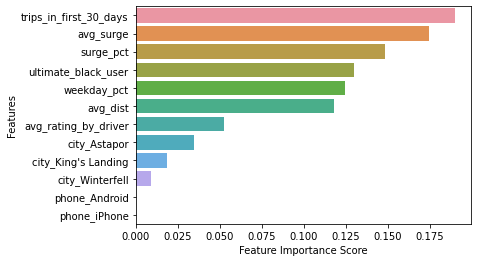

In [24]:
feature_score = pd.Series(xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_names = X_train.columns

sns.barplot(x=feature_score, y=feature_names) #graphing top 7 most important features
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.show()

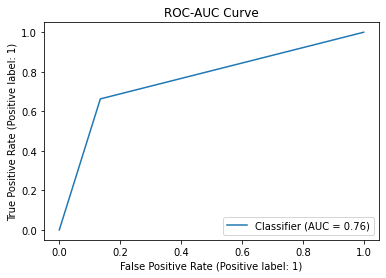

In [25]:
metrics.RocCurveDisplay.from_predictions(y_test, xgb_pred)
plt.title('ROC-AUC Curve')
plt.show()

AUC Score is pretty good, 76%. The most important features are the number of trips in the first 30 days, the average surge multiplier across all trips, the percent surge priced trips the user takes, whether they are an ultimate black user, the percent of weekday trips they take and the average distance per ride.

# Question #3

Based on the most important features, it appears that those who use the service most frequently and most ambivalent towards paying surge prices are the most likley to be retained.  Most of the important features sound like personal choices and therefore nothing the company can act upon, demographic data would be useful to gain additional insight.  However the most important feature, trips in the first 30 days, can be exploited by Ultimate through notifications, discounts, deals, promotions etc. Whatever can be done to get a user to get used to using the service as much as possible as soon as possible after signup will increase Ultimate's chances of retaining them.